# Testbench Reporting Notebook

# Imports

In [2]:
# Imports
import os, glob, yaml
from fnmatch import fnmatch
import numpy as np
import pandas as pd
import ruamel.yaml as ry
import matplotlib.pyplot as plt
from openfast_io import FileTools


# Helper functions
will remain here until they have stablized.

In [3]:
def plot_binned_data(dfs, channels=None, fig=None):
    """
    Plots time series from defined channels within the dataframe (df, binned_*.p).
    """

    if not type(dfs) == list:
        dfs = [dfs]
    
    if channels is None:
        channels = ['RootMyb1','TwrBsMyt','LSSTipMya','YawBrMyp']

    if fig is None:
        fig, ax = plt.subplots(len(channels), 1, figsize=(10,3*len(channels)), tight_layout=True)
    else: 
        ax = fig.axes
    if len(ax) != len(channels):
        raise ValueError(f"Figure provided does not have the same number of axes as channels. Expected: {len(channels)}, actual: {len(axes)}.")

    for n, channel in enumerate(channels):
        for df in dfs:
            ax[n].scatter(np.sqrt(df['Wind1VelX']**2+df['Wind1VelY']**2), abs(df[channel]))
        ax[n].axhline(y=np.max(abs(df[channel])), color='k', linestyle='--')
        ax[n].set_xlabel('Wind speed')
        ax[n].set_ylabel(channel)
        ax[n].grid()
        ax[n].set_xlim([0, 30])
    
    dt = df['Time'].iloc[1] - df['Time'].iloc[0]
    fig.set_size_inches(7,len(channels)*3)
    return fig, ax, dt

def plot_characteristic_loads(data, cases=None, channels=None):
    """
    Plots characteristic loads from yaml file for defined channels and DLC cases.
    """

    if not type(data) == list:
        data = [data]

    if cases is None:
        cases = ['1.1','1.3']
    
    if channels is None:
        channels = ['RootMyb1','TwrBsMyt','LSSTipMya','YawBrMyp']

    for case in cases:
        fig, ax = plt.subplots(len(channels), 1, figsize=(7,2*len(channels)), tight_layout=True)

        ax[0].set_title(f"DLC {case}")
        for n, channel in enumerate(channels):
            for k, datum in enumerate(data):
                ax[n].scatter(datum[case][channel]['wind_speed'], datum[case][channel]['load_values'])
                ax[n].axhline(y=datum[case][channel]['characteristic_load'], color='C'+str(k), linestyle='--')
            ax[n].set_xlabel('Wind speed')
            ax[n].set_ylabel(channel)
            ax[n].grid()

    return fig, ax


# Function for reading case matrix
def read_cm(fname_case_matrix):
    cm_dict = FileTools.load_yaml(fname_case_matrix, package=1)
    cnames = []
    for c in list(cm_dict.keys()):
        if isinstance(c,ry.comments.CommentedKeySeq):
            cnames.append(tuple(c))
        else:
            cnames.append(c)

    cm = pd.DataFrame(cm_dict, columns=cnames)
    
    if ('DLC','Label') in cm:

        cm[('DLC','Label')].unique()

        dlc_inds = {}

        for dlc in cm[('DLC','Label')].unique():
            dlc_inds[dlc] = cm[('DLC','Label')] == dlc

        return cm, dlc_inds
    
    else:
        return cm, None

def stability_analysis(comparelist, case_matrix):
    # NOTE: This code assumes that same dlcs has been run in all the cases.
    case = comparelist[0]  # TODO: check this
    casematrix = case_matrix
    
    allrampdlcs = []
    allstepdlcs = []
    allsteadystepdlcs = []
    allsteadydlcs = []

    for dlc, dlctype in casematrix["DLC"].items():
        match dlctype:
            case "Ramp":
                allrampdlcs.append(dlc)
            case "Step":
                allstepdlcs.append(dlc)
                if casematrix[('InflowWind', 'WindType')][dlc] == 2:
                    allsteadystepdlcs.append(dlc)
            case "Steady":
                allsteadydlcs.append(dlc)
    if allrampdlcs:
        plot_timeseries(comparelist, allrampdlcs)
    if allstepdlcs:
        plot_timeseries(comparelist, allstepdlcs)
    if allsteadydlcs:
        plot_timeseries(comparelist, allsteadydlcs)
    if allsteadystepdlcs:
        measure_stepresponse(comparelist,allsteadystepdlcs)



def plot_timeseries(comparelist, alldlcs):
    channels = ["Wind1VelX_[m/s]", "GenTq_[kN-m]", "BldPitch1_[deg]", "RtSpeed_[rpm]"]
    for dlc in alldlcs:
        fig, axs = plt.subplots(len(channels), 1)
        if len(channels) == 1:
            axs = [axs]
        axs = axs.flatten()

        for case in comparelist:
            dfdlc = pd.read_pickle(
                os.path.join("outputs", case, f"iteration_0/timeseries/{dlc}.p")
            )
            for i_chan, chan in enumerate(channels):
                axs[i_chan].plot(dfdlc["Time"], dfdlc[chan.split("_")[0]], label=case)
                axs[i_chan].set_ylabel(chan.replace("_", "\n"))
                axs[i_chan].grid(True)

        fig.set_figheight(2 * len(channels))
        fig.set_figwidth(7)
        axs[0].set_title(
            f"Stability analysis using a {dlc.split('_')[0][3:].lower()} inflow with {dlc}"
        )
        axs[0].legend()
        axs[-1].set_xlabel("Time")
        # fig.savefig(f"{dlc}_StabilityAnalysis.png")

def measure_stepresponse(comparelist,alldlcs):
    for case in comparelist:
        with open(os.path.join("outputs", case, "case_matrix_combined.yaml"), "r") as f:
            yaml = YAML()
            casematrix = yaml.load(f)
        for dlc in alldlcs:

            # Read step wind information
            windfile_step = casematrix[('InflowWind', 'FileName_Uni')][dlc]
            with open(os.path.join("outputs",case,'wind',windfile_step),'r') as f:
                winddata = f.readlines()
            steptime = float(winddata[7].split()[0])
            totaltime = casematrix[('Fst', 'TMax')][dlc]

            dfdlc = pd.read_pickle(
                os.path.join("outputs", case, f"iteration_0/timeseries/{dlc}.p")
            )
            channels = ["GenTq_[kN-m]", "BldPitch1_[deg]", "RtSpeed_[rpm]"]
            time = dfdlc['Time']
            for chan in channels:
                y = dfdlc[chan.split("_")[0]]

                # Steady state value
                yss = np.mean(y[time>steptime])

                # Overshoot
                overshoot = (np.max(y) - yss) / yss * 100

                # Rise time
                y_10perc = 0.1 * yss
                y_90perc = 0.9 * yss
                rise_start = time[np.where(y >= y_10perc)[0][0]]
                rise_end = time[np.where(y >= y_90perc)[0][0]]
                rise_time = rise_end - rise_start

                # Settling time
                # within_tol_2percent = np.abs(y - yss) <= 0.02 * yss
                # settling_time_2percent = time[np.where(within_tol_2percent)[0][-1]] if np.all(within_tol_2percent) else time[-1]
                print(f"for chan = {chan}, overshoot is {overshoot}, risetime is {rise_time}")# , settline_time is {settling_time_2percent}")


def plot_dels_at_ws(dfs, sumfs, channels = None, cases = None, fig=None):
    """
    Plot DELs (from df DELs file) for different wind speeds (from sumf summary file).
    """

    if not type(dfs) == list:
        dfs = [dfs]    
    if not type(sumfs) == list:
        sumfs = [sumfs]  

    if channels is None:
        channels = ['RootMyb1','TwrBsMyt','LSSTipMya','YawBrMyp']

    if fig is None:
        fig, ax = plt.subplots(len(channels), 1, figsize=(7,3*len(channels)), tight_layout=True)
    else: 
        ax = fig.axes
    if len(ax) != len(channels):
        raise ValueError(f"Figure provided does not have the same number of axes as channels. Expected: {len(channels)}, actual: {len(ax)}.")

    ws = []
    for sumf in sumfs:
        ws.append(np.sqrt( sumf.loc[cases]['Wind1VelX']['mean'].values**2 + sumf.loc[cases]['Wind1VelY']['mean'].values**2 ))
    for n, channel in enumerate(channels):
        for k, df in enumerate(dfs):
            ax[n].scatter(ws[k], abs(df.loc[cases][channel]))
            ax[n].axhline(y=np.max(abs(df.loc[cases][channel])), color='C'+str(k), linestyle='--')
        ax[n].set_xlabel('Wind speed')
        ax[n].set_ylabel(channel)
        ax[n].grid()

def parse_freq_string(freq_string):
    b = freq_string.replace('[','').replace(']','').split(',')
    return [float(bb) for bb in b]


def report_psd_ranking(psd_summ, channels_to_analyze, n_largest=4, sort_index=0):
    """
    Reports the n_largest PSD values for each channel and frequency from the psd_summ DataFrame.
    psd_summ: List of DataFrames, each containing PSD values for different controllers/channels/frequencies.
    channels_to_analyze: List of channels to analyze.
    n_largest: Number of largest values to report.
    sort_index: Index of the column to sort by when reporting.
    """

    b = []  # List to store series for each controller/channel/frequency
    for i, psd_summ_i in enumerate(psd_summ):
        for chan in channels_to_analyze:
            for col in psd_summ_i[chan].columns:
                a = psd_summ_i[chan][col]  # Series of PSD values for this channel/frequency
                b.append(a)

                # When at the last controller, combine all into a DataFrame and print sorted results
                if i == len(psd_summ)-1:  # last case/controller
                    fdf = pd.DataFrame({l: s for l, s in zip(labels, b)})  # Combine all controllers into one DataFrame

                    print(f'{n_largest} highest cases for {chan} at f = {col}')
                    print(fdf.sort_values(by=labels[sort_index], ascending=False).head(n_largest))
                    print('')

def plot_psd_cases(psd_folder, cases_to_plot, channels):
    for case_name in cases_to_plot:
        psd_df = pd.read_pickle(os.path.join(psd_folder,f'{case_name}.p'))
    
        fig, axs = plt.subplots(len(channels),1,sharex=True)
        fig.set_size_inches(7,7)
        for ax, chan in zip(axs,channels):
            ax.loglog(psd_df[chan])
            ax.set_ylabel(chan)
    
            # Plot summary measures (avg, values)
            sum_data = psd_summ.loc[case_name][chan]
            yl = ax.get_ylim()
            # print(yl)
            for item in sum_data.items():
                freqs = parse_freq_string(item[0])
                data = item[1]
    
                if len(freqs) > 1:
                    ax.fill_betweenx(yl, freqs[0], freqs[1], alpha=0.1, color='k')
                    x = np.mean(np.array(freqs))
    
                else:
                    ax.axvline(freqs[0],0,1, color='k')
                    x = freqs[0]
            
                ax.plot(x,data,'x',color='k')
    
            
            ax.set_ylim(yl)   # re-set ylim
            
            
        
        axs[-1].set_xlabel('Freq. (Hz)')     
        fig.suptitle(case_name)



# Start here, select directories
For now, only set up one directory

In [4]:
run_with_mpi = True   # if MPI was used to run cases, will change file structure slightly
output_folders = ['/projects/ssc/dzalkind/shared/17_nrel_5mw_rosco',
                 '/scratch/jfrederi/ROSCO_runs/19_controller_test_bench/outputs/23_5MW_setup_AWC']

#####
summary_folders = []
for output_folder in output_folders:
    if run_with_mpi:
        output_folder = os.path.join(output_folder,'rank_0')
    summary_folders.append(os.path.join(output_folder,'iteration_0'))

    # load case matrix
    cm, _ = read_cm(os.path.join(output_folder,'case_matrix_combined.yaml'))
    unique_dlcs = cm['DLC'].unique()

# Binned data (all)

Text(0.5, 0.98, 'All binned data. Window = 20.0 sec.')

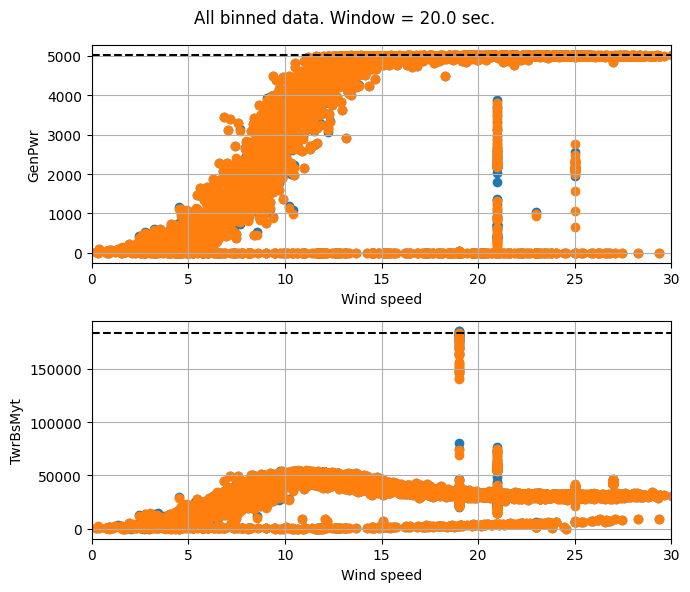

In [5]:
bin_channels = ['GenPwr','TwrBsMyt']

######
bin_dfs = []
for summary_folder in summary_folders:
    bin_dfs.append(pd.read_pickle(os.path.join(summary_folder,'binned_all.p')))
    
fig, axs, dt = plot_binned_data(bin_dfs, channels=bin_channels, fig=None)
fig.suptitle(f'All binned data. Window = {dt} sec.')

# Binned data (by DLC)

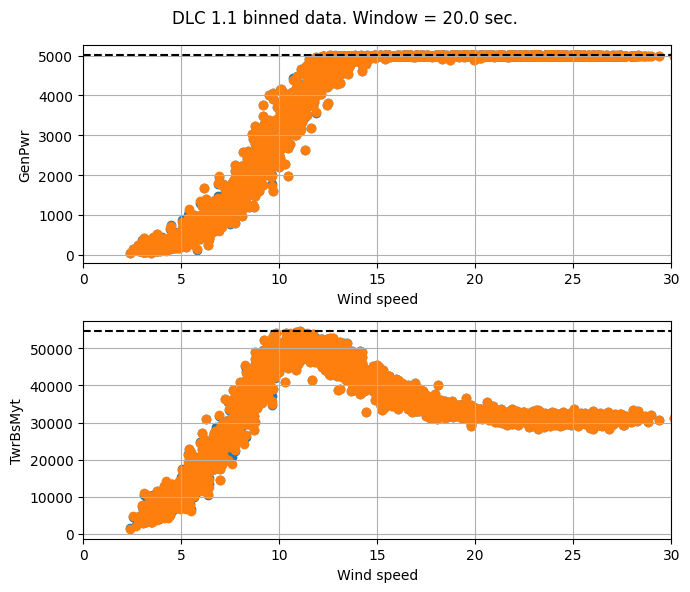

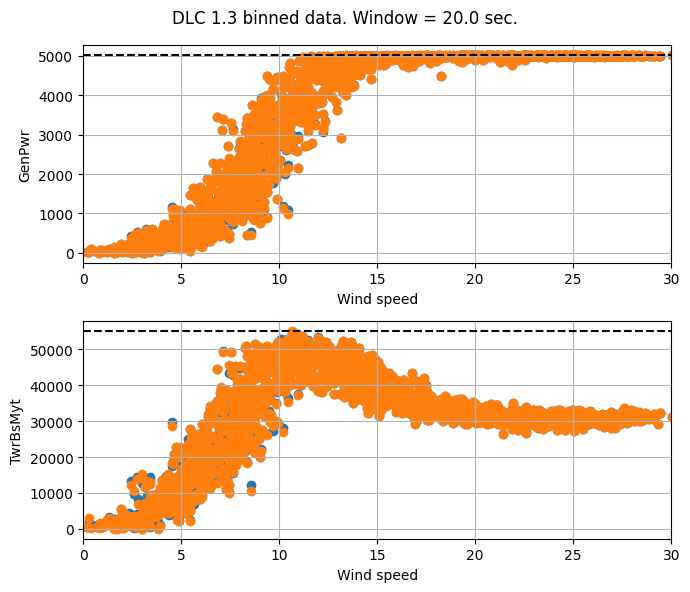

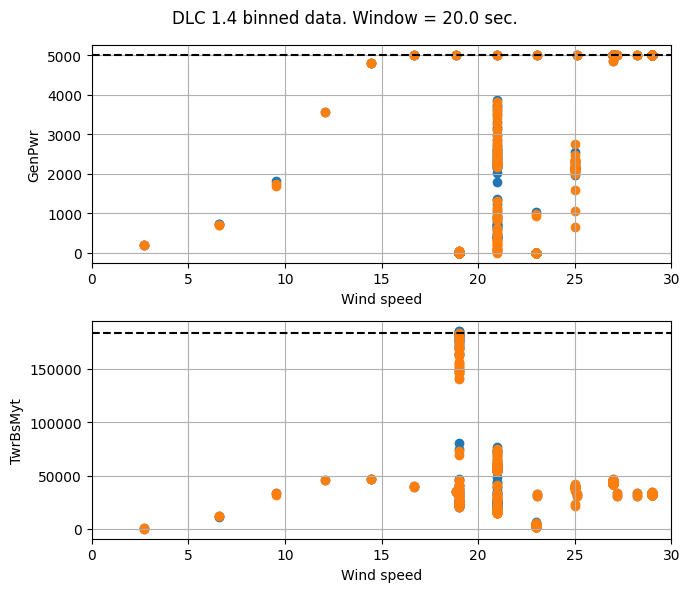

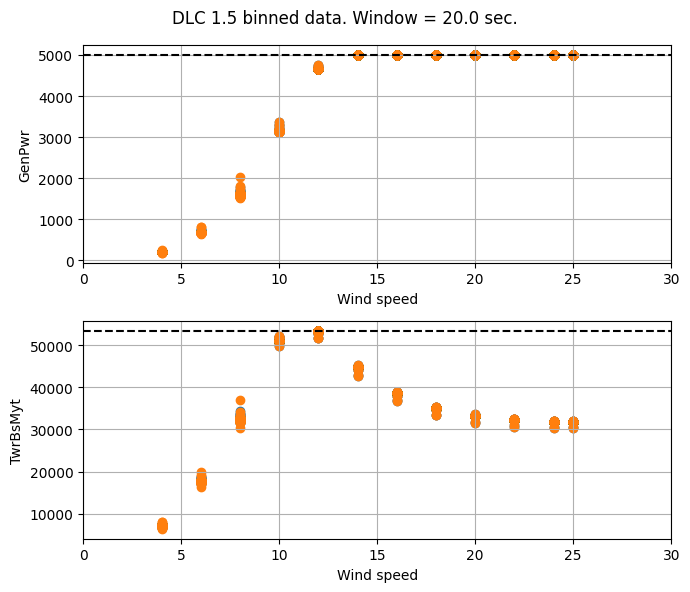

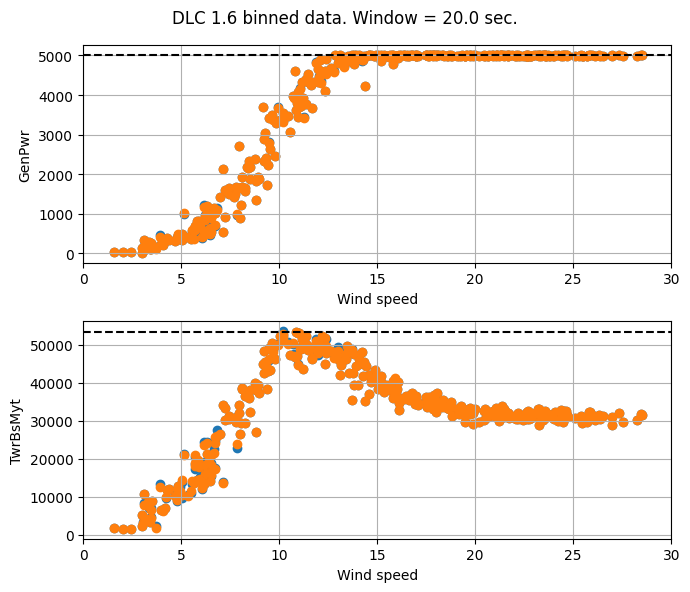

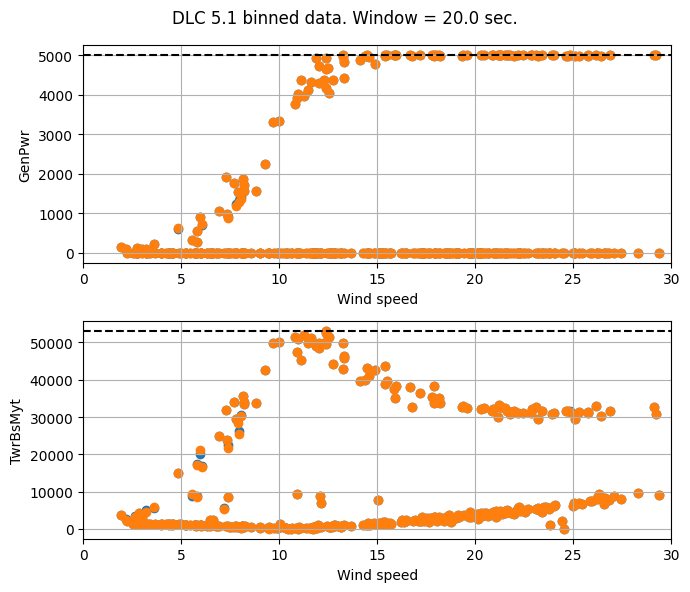

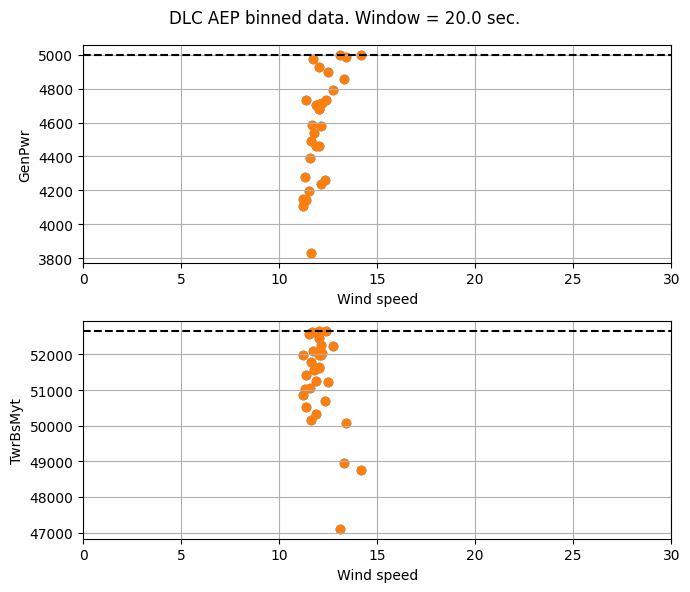

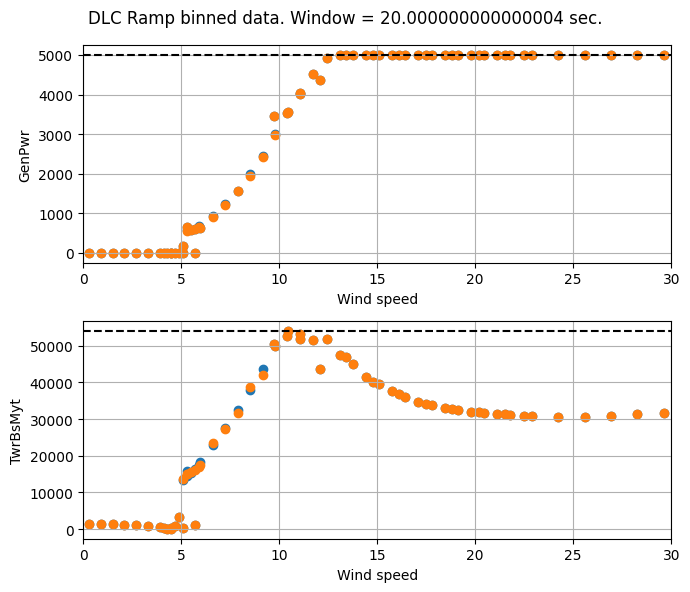

In [6]:
for dlc in unique_dlcs:
    bin_dfs = []
    for summary_folder in summary_folders:
        bin_dfs.append(pd.read_pickle(os.path.join(summary_folder,f'binned_dlc{dlc}.p')))
    fig, axs, dt = plot_binned_data(bin_dfs, channels=bin_channels, fig=None)
    fig.suptitle(f'DLC {dlc} binned data. Window = {dt} sec.')

# Characteristic Loads

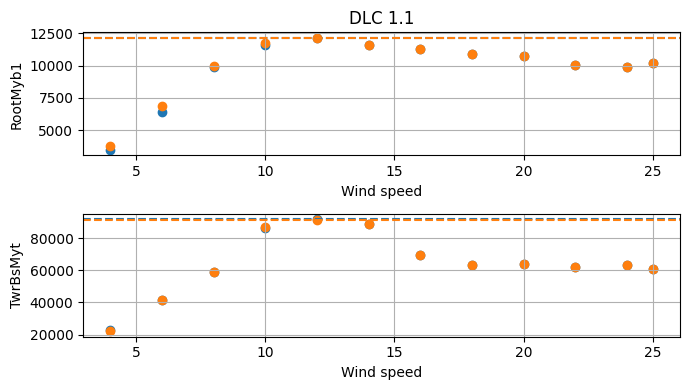

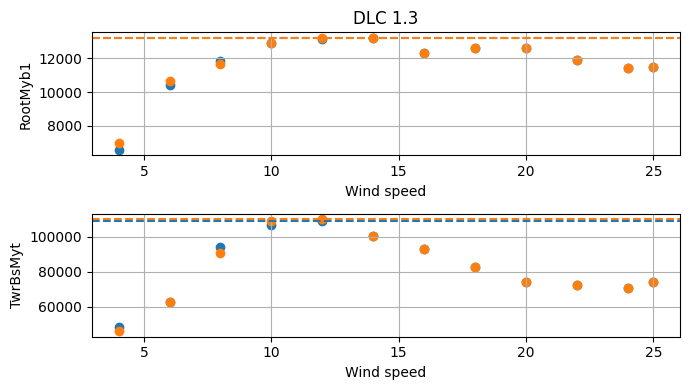

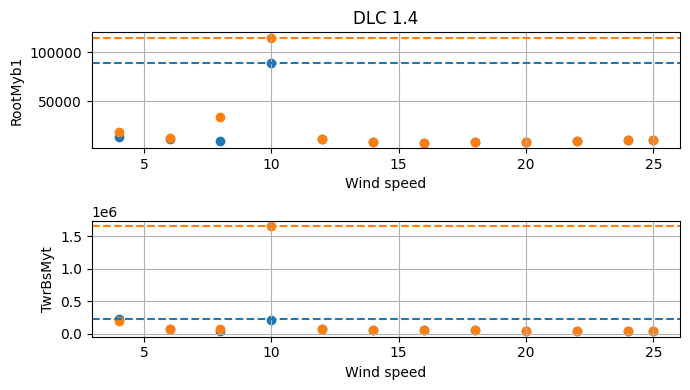

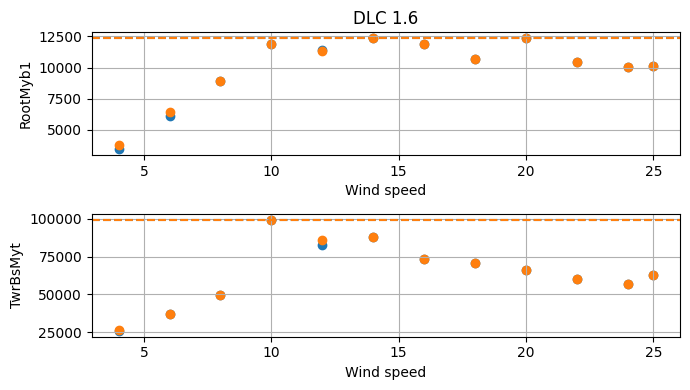

In [ ]:
char_channels = ['RootMyb1','TwrBsMyt']
cases = ['1.1','1.3','1.4']


#######
char_loads = []
for summary_folder in summary_folders:
    char_loads.append(FileTools.load_yaml(os.path.join(summary_folder, 'characteristic_loads.yaml'), package=1))

_,_ = plot_characteristic_loads(char_loads, cases, channels=char_channels)

# Damage Equivalent Loads

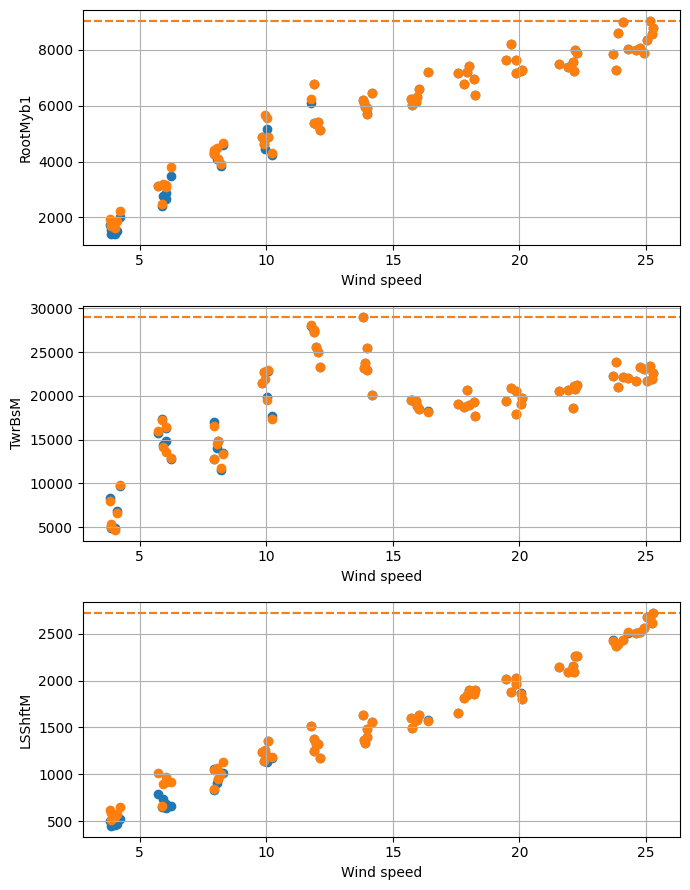

In [ ]:
del_channels = ['TwrBsMyt','RootMyb1']



###########
dd = []
ss = []
for summary_folder in summary_folders:
    dd.append(pd.read_pickle(os.path.join(summary_folder, 'DELs.p')))
    ssi = pd.read_pickle(os.path.join(summary_folder, 'summary_stats.p'))
    ss.append(ssi)

cases = [index for index, element in enumerate(dd[0].index) if '1.1' in element]
cases = dd[0].index[cases]

channels = ['RootMyb1','TwrBsM','LSShftM']

plot_dels_at_ws(dd, ss, cases=cases, channels=channels)

In [ ]:
ss
# summary_folder

,Time,Wind1VelX,Wind1VelY,Wind1VelZ,Azimuth,BldPitch1,BldPitch2,BldPitch3,GenSpeed,IPDefl1,...,RootFzr,RootMxr,RootMyr,RootMzr,TipTDxr,TipTDyr,TipTDzr,TipRDxr,TipRDyr,TipRDzr
,min,min,min,min,min,min,min,min,min,min,...,integrated,integrated,integrated,integrated,integrated,integrated,integrated,integrated,integrated,integrated
DLC1.1_0_testbench_00.outb,120.0,1.319433,-2.719120,-1.589386,0.002240,0.000000,0.000000,0.000000,317.998999,-0.633007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLC1.1_0_testbench_01.outb,120.0,1.858745,-2.418746,-1.448945,0.000571,0.000000,0.000000,0.000000,321.404851,-0.629618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLC1.1_0_testbench_02.outb,120.0,1.484935,-2.127035,-1.794146,0.000666,0.000000,0.000000,0.000000,307.967157,-0.651341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLC1.1_0_testbench_03.outb,120.0,1.491177,-2.103328,-1.565014,0.004247,0.000000,0.000000,0.000000,330.589066,-0.645370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLC1.1_0_testbench_04.outb,120.0,1.682065,-2.533374,-1.415372,0.000742,0.000000,0.000000,0.000000,332.549327,-0.638958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DLCRamp_7_testbench_0.outb,20.0,0.000000,-0.000000,0.000000,0.003702,0.000000,0.000000,0.000000,-0.030029,-0.475908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLCRamp_8_testbench_0.outb,20.0,4.000000,-0.000000,0.000000,0.005241,0.000000,0.000000,0.000000,44.207236,-0.655979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DLCRamp_9_testbench_0.outb,20.0,5.000000,-0.000000,0.000000,0.001961,0.000000,0.000000,0.000000,593.600511,-1.068743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot Stability Cases

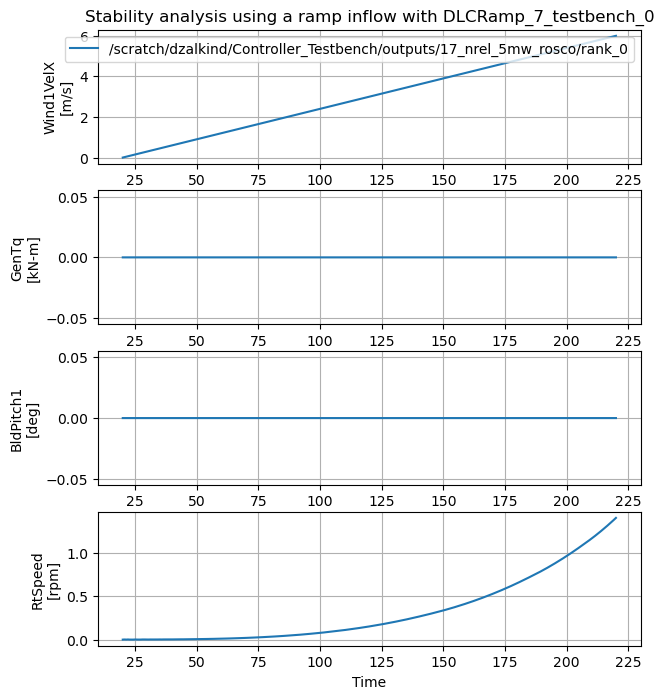

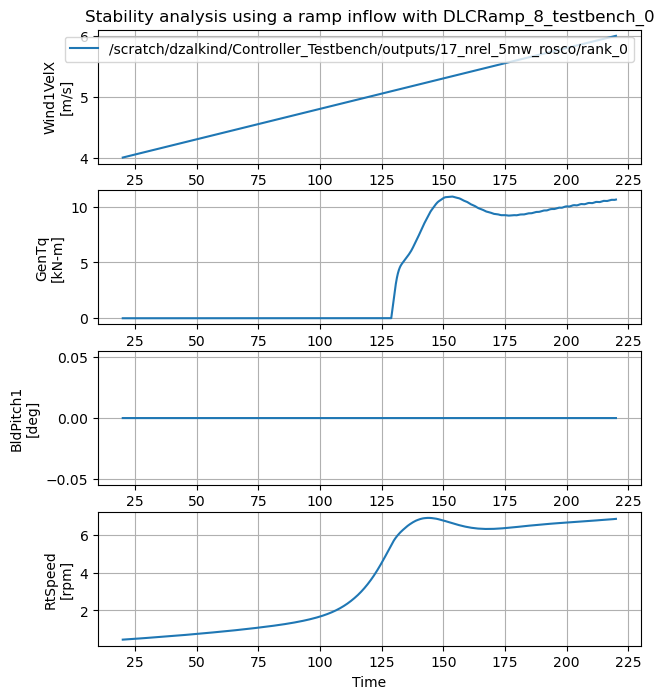

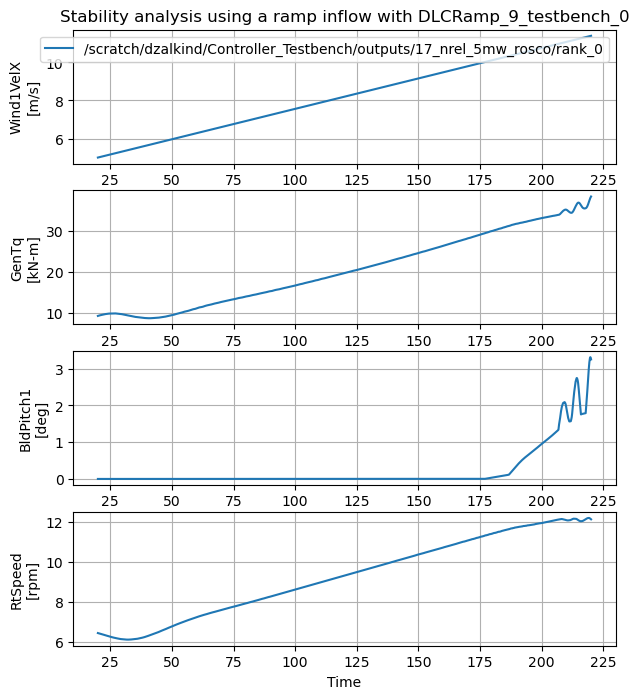

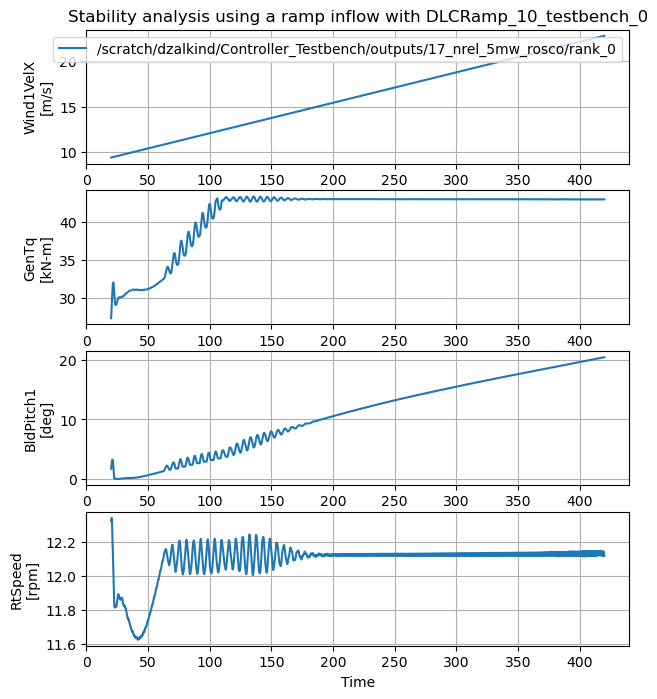

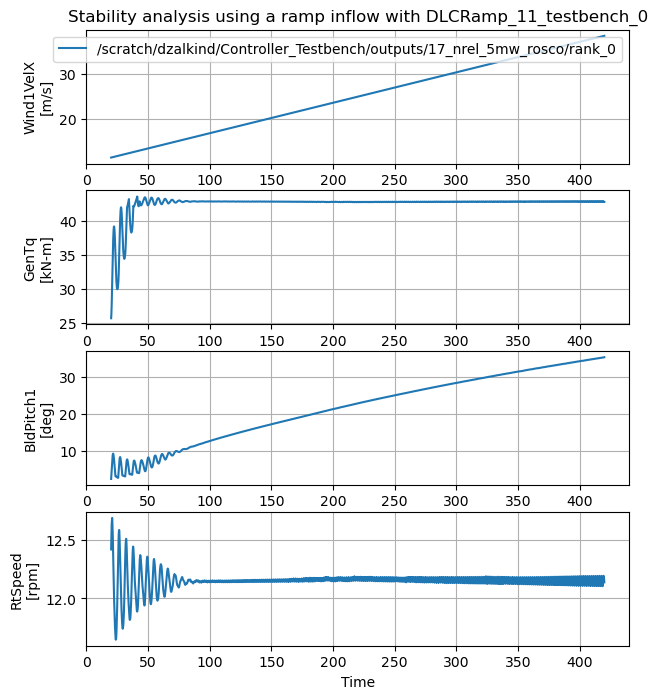

In [ ]:


#####
comparelist = [output_folder]

stability_analysis(comparelist,cm)

# Frequency Measures
1. N largest PSDs
2. PSD comparisons



In [ ]:
channels_to_analyze = ['TwrBsMyt','RootMyb1','BldPitch1','PtfmPitch']
n_largest = 4

#############################################################################

psd_folder = os.path.join(summary_folder,'psds')
psd_summ = pd.read_pickle(os.path.join(summary_folder,'psd_summary.p'))

report_psd_ranking(psd_summ,channels_to_analyze,n_largest)

# psd_summ


4 highest cases for TwrBsMyt at f = [0.18149, 0.221826]
case_name
DLC1.4_2_testbench_08    3.814926e+07
DLC1.3_1_testbench_25    2.462531e+07
DLC1.3_1_testbench_08    2.366366e+07
DLC1.3_1_testbench_20    2.348832e+07
Name: [0.18149, 0.221826], dtype: float64

4 highest cases for TwrBsMyt at f = [0.54448, 0.66547]
case_name
DLC1.4_2_testbench_08    7.424016e+07
DLC1.3_1_testbench_25    4.668045e+07
DLC1.3_1_testbench_20    4.438465e+07
DLC1.3_1_testbench_08    4.396590e+07
Name: [0.54448, 0.66547], dtype: float64

4 highest cases for RootMyb1 at f = [0.18149, 0.221826]
case_name
DLC1.4_2_testbench_23    5.533231e+06
DLC1.4_2_testbench_21    5.104590e+06
DLC1.4_2_testbench_19    4.241559e+06
DLC1.4_2_testbench_17    3.337423e+06
Name: [0.18149, 0.221826], dtype: float64

4 highest cases for RootMyb1 at f = [0.54448, 0.66547]
case_name
DLC1.4_2_testbench_23    1.169088e+07
DLC1.4_2_testbench_21    1.078001e+07
DLC1.4_2_testbench_19    8.939384e+06
DLC1.4_2_testbench_17    7.013846e+06
Na

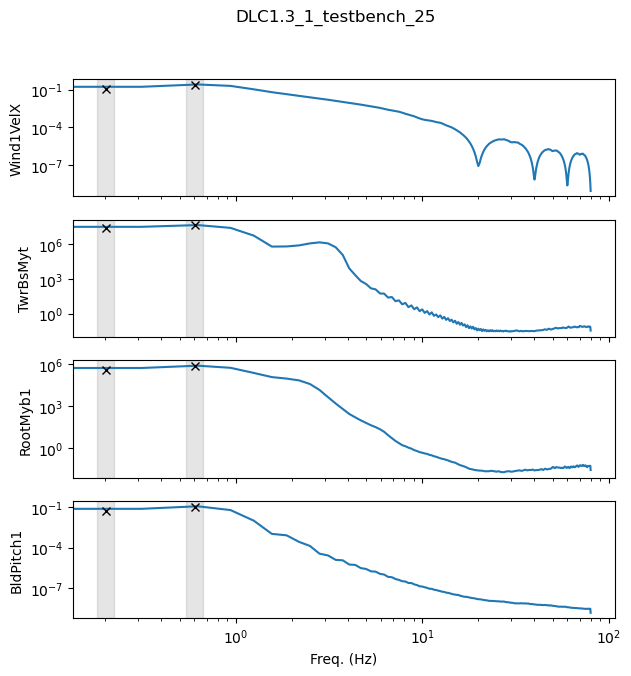

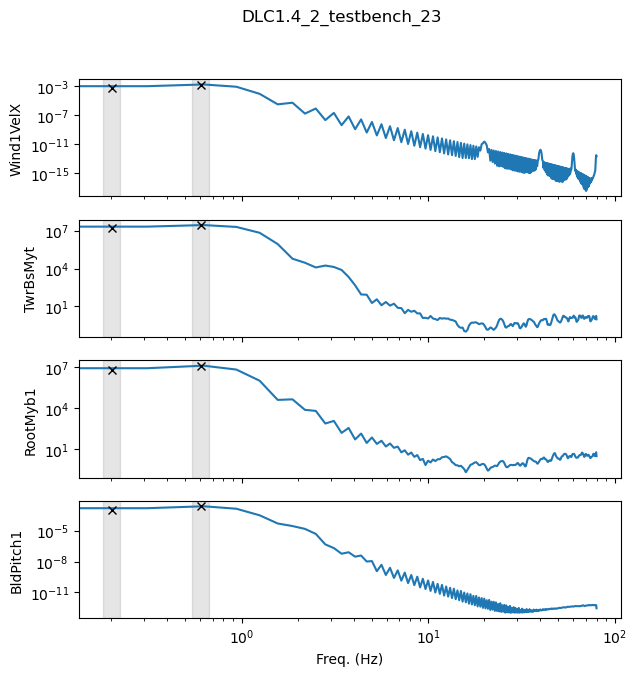

In [ ]:
cases_to_plot = ['DLC1.3_1_testbench_71','DLC1.4_2_testbench_06'] 
channels = ['Wind1VelX','TwrBsMyt','RootMyb1','BldPitch1']


#############################################################################
psd_folders = []
for summary_folder in summary_folders:
    psd_folders.append(os.path.join(summary_folder,'psds'))


for case_name in cases_to_plot:

    psd_df = []
    psd_summ = []
    for psd_folder in psd_folders:
        psd_df.append(pd.read_pickle(os.path.join(psd_folder,f'{case_name}.p')))
        psd_summ.append(pd.read_pickle(os.path.join(summary_folder,'psd_summary.p')))

    fig, axs = plt.subplots(len(channels),1,sharex=True)
    fig.set_size_inches(7,7)
    for ax, chan in zip(axs,channels):
        for i, (psd_df_i, psd_summ_i) in enumerate(zip(psd_df, psd_summ)):
            ax.loglog(psd_df_i[chan])

            # Plot summary measures (avg, values)
            sum_data = psd_summ_i.loc[case_name][chan]
            yl = ax.get_ylim()

        
        
            for item in sum_data.items():
                freqs = parse_freq_string(item[0])
                data = item[1]

                if len(freqs) > 1:
                    ax.fill_betweenx(yl, freqs[0], freqs[1], alpha=0.1, color='k')
                    x = np.mean(np.array(freqs))

                else:
                    ax.axvline(freqs[0],0,1)
                    x = freqs[0]
            
                ax.plot(x,data,'x',color='k')

        ax.set_ylabel(chan)
        
        ax.set_ylim(yl)   # re-set ylim
        
        
    
    axs[-1].set_xlabel('Freq. (Hz)')     
    fig.suptitle(case_name)



# AEP 

/tmp/ipykernel_434471/4157114152.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss_aep['AEP_WindSpeed'] = ws_i_mapped


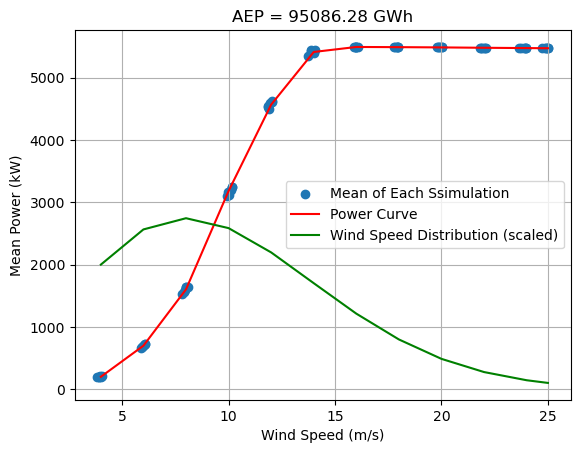

In [11]:

summary_folder

ind = 1

aep_info = FileTools.load_yaml(os.path.join(summary_folder,'aep_info.yaml'))

# Reduce summary stats to AEP relevant cases
ind_aep = np.array(cm['DLC'] == 'AEP')
ss_aep = ss[ind].loc[ind_aep]

# Unpack AEP information
mean_power = ss_aep['GenPwr']['mean']
ws_i = ss_aep['Wind1VelX']['mean']
aep_ws = aep_info['mean_wind_speeds'] 


# Map each ws_i value to the nearest aep_ws value
ws_i_mapped = ws_i.apply(lambda x: aep_ws[np.abs(np.array(aep_ws) - x).argmin()])
ss_aep['AEP_WindSpeed'] = ws_i_mapped

ss_aep['AEP_WindSpeed'] 

# Compute mean power for each wind speed in AEP power curve
grouped = ss_aep.groupby('AEP_WindSpeed')
mean_power_ws = []
for ws, group in grouped:
    mean_power_ws.append(group['GenPwr']['mean'].mean())

aep_info['mean_power'] = mean_power_ws

# Scale the probability distribution for plotting
max_power = np.max(aep_info['mean_power'])
prob_scaled = np.array(aep_info['probability']) * max_power / np.max(aep_info['probability']) / 2


plt.scatter(ss_aep['Wind1VelX']['mean'], ss_aep['GenPwr']['mean'],label='Mean of Each Ssimulation')
plt.plot(np.unique(aep_info['mean_wind_speeds']), aep_info['mean_power'], label='Power Curve', color='r')

aep_info['mean_wind_speeds']

plt.plot(aep_info['mean_wind_speeds'], prob_scaled, label='Wind Speed Distribution (scaled)', color='g')
plt.legend()


plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Mean Power (kW)')

AEP_title = f'AEP = {aep_info['AEP']/1e6:.2f} GWh'

plt.title(AEP_title)
plt.grid()






# Timeseries Plotting

In [12]:
cases_to_plot = ['DLC1.4_2_testbench_03','DLC1.6_3_testbench_03'] 
channels = ['Wind1VelX','TwrBsMyt','RootMyb1','BldPitch1']

#######################################################################

# TODO: plot timeseries


